## Deep learning для обработки звука

#### В этом задании

* Форматы представления аудиоданных в задачах глубинного обучения
* Алгоритм построения мел-спектрограммы
* Модели для классификации аудиозаписей: рекуррентные и сверточные классификаторы аудиоданных
* Алгоритм аугментации аудиоданных SpecAugment

In [ ]:
# !pip install torch==1.11.0 torchaudio==0.11.0 # numpy==1.20.0
# !pip install torch torchaudio

In [ ]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import torch
import torchaudio
from IPython import display
from IPython.display import clear_output
from sklearn.metrics import confusion_matrix
from torch import nn
from torch.utils.data import DataLoader, Dataset, Subset

%matplotlib inline

# assert torch.__version__.startswith("1.11.0")
# assert torchaudio.__version__ == "0.11.0"

device = "cuda:0"
# device = "cpu"

#### Классификация аудиозаписей

Задача - классифицировать аудиозаписи из датасета [UrbanSound8K](https://urbansounddataset.weebly.com/urbansound8k.html).

Данный датасет состоит из 8732 записей, разбитых на train/val/test датасеты.

![image](https://paperswithcode.com/media/datasets/UrbanSound8K-0000003722-02faef06.jpg)

Каждая аудиозапись содержит запись шума города и принадлежит одному из 10 классов:

`[air_conditioner, car_horn, children_playing, dog_bark, drilling, engine_idling, gun_shot, jackhammer, siren, street_music]`


#### Данные

Датасет из [Google Drive](https://drive.google.com/file/d/1BsN_hscJO5CEeWAHbK_U8ILx2m_b1B1f/view?usp=sharing).

In [ ]:
# синхронизация тетрадки с гугл-диском
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# скачивание и распаковка данных в папку `./data`
!rm -r ./data
!mkdir ./data/
!pip install gdown
!cd ./data && gdown --id '1BsN_hscJO5CEeWAHbK_U8ILx2m_b1B1f' && unzip 06_audio_dataset

In [ ]:
# классы данных
classes = [
    "air_conditioner",
    "car_horn",
    "children_playing",
    "dog_bark",
    "drilling",
    "engine_idling",
    "gun_shot",
    "jackhammer",
    "siren",
    "street_music",
]

**Реализация `AudioDataset` класса**

Класс принимает путь к файлам `train_part.csv` и `val_part.csv` и возращает тройки объектов `(x, y, len)`, где `x` - аудиозапись, `y` - класс аудиозаписи, `len` - длина аудиозаписи.

In [ ]:
class AudioDataset(Dataset):
    def __init__(
        self,
        path_to_csv: str,
        path_to_folder: str,
        pad_size: int = 384000,
        sr: int = 44100,
    ):
        self.csv: pd.DataFrame = pd.read_csv(path_to_csv)[["ID", "Class"]]
        self.path_to_folder = path_to_folder
        self.pad_size = pad_size

        self.sr = sr

        self.class_to_idx = {classes[i]: i for i in range(10)}

    def __getitem__(self, index: int):
        id, cl = self.csv.iloc[index]
        y = self.class_to_idx[cl]

        path = os.path.join(self.path_to_folder, str(id) + '.wav')
        wav, sample_rate = torchaudio.load(path) # подгрузка wav файлов

        len = wav.shape[1]

        if sample_rate != self.sr:
            resampler = torchaudio.transforms.Resample(sample_rate, self.sr)
            wav = resampler(wav)

        # паддинг аудиозаписи - если она короче чем `pad_size` параметр, она дополняется нулями
        if wav.shape[1] < self.pad_size:
            x = torch.zeros(wav.shape[0], self.pad_size, dtype=torch.float32)
            x[:, :wav.shape[1]] = wav
            x = x.squeeze()
        else:
            x = wav.squeeze()

        instance = {'x': x, 'y': y, 'len': len}
        return instance

    def __len__(self):
        return self.csv.shape[0]

In [ ]:
# создание датасетов
train_dataset = AudioDataset(
    "./data/urbansound8k/train_part.csv", "./data/urbansound8k/data"
)
val_dataset = AudioDataset(
    "./data/urbansound8k/val_part.csv", "./data/urbansound8k/data"
)

In [ ]:
# проверка размеров датасетов
assert len(train_dataset) == 4500
assert len(val_dataset) == 935

In [ ]:
# проверка возращаемых значений __getitem__
item = train_dataset.__getitem__(0)

assert item["x"].shape == (384000,)
assert item["y"] == 0
assert item["len"] == 176400

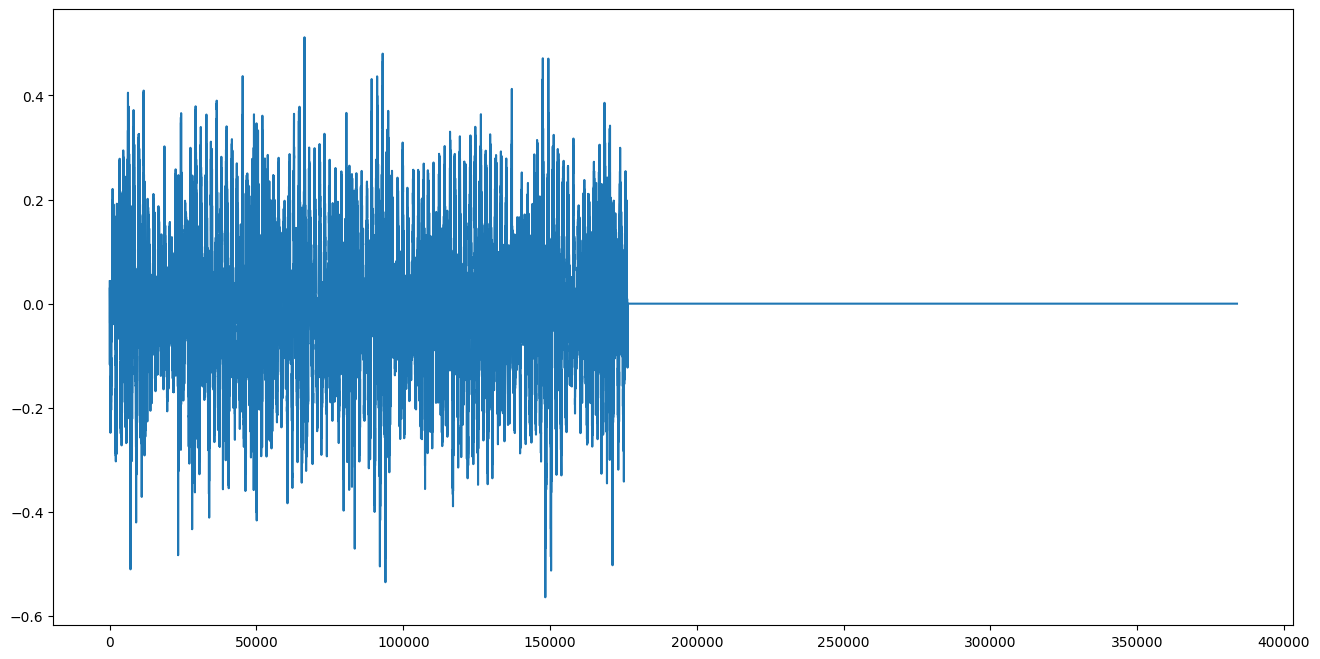

In [ ]:
# отрисовка и проигрывание аудиозаписи
item = train_dataset.__getitem__(0)
plt.figure(figsize=(16, 8))
plt.plot(item["x"])

display.Audio(item["x"], rate=train_dataset.sr)

In [ ]:
# создание даталоадеров
train_dataloader = DataLoader(
    train_dataset, batch_size=32, shuffle=True, pin_memory=True, drop_last=True
)
val_dataloader = DataLoader(val_dataset, batch_size=32, pin_memory=True)

#### Рекуррентная сеть для классификации аудиозаписей по сырому сигналу

По своей сути аудиозапись является ни чем иным, как временным рядом - замеры микрофона делаются через равные промежутки времени и хранятся в виде последовательности. Как известно, рекуррентные сети отлично подходят для работы с различными последовательностями, в том числе и с временными рядами. Поэтому обучим простую реккурентную сеть для классификации аудиозаписей (рисунок).

Сеть:
1. Разбивает аудиозапись на окошки размером `1024` с шагом `256`.
2. Применяет к каждому получившемуся окну аудиосигнала полносвязную сеть с активациями `ReLU` и  внутренними размерностями `(1024 -> 256 -> 64 -> 16)`.
3. По получившимся последовательностям проходится двунаправленной LSTM с двумя слоями.
4. Склеивает последние `hidden_state` для каждого слоя и применяет к ним полносвязную сеть `(2 * hidden_size * num_layers -> 256 -> 10)` с активацией `ReLU`.

<center>
<img src="https://raw.githubusercontent.com/hse-ds/iad-applied-ds/2020-2023/2022/hw/hw2/imgs/rnn_raw.png" height="500">
</center>

**Реализация класса рекуррентной сети**

In [ ]:
class RecurrentRawAudioClassifier(nn.Module):
    def __init__(
        self,
        num_classes=10,
        window_length=1024,
        hop_length=256,
        hidden=256,
        num_layers=2,
    ) -> None:
        super().__init__()

        self.window_length = window_length
        self.hop_length = hop_length

        self.num_layers = num_layers
        self.hidden = hidden
        self.num_classes = num_classes

        self.first_mlp = nn.Sequential(
            nn.Linear(1024, 256),
            nn.BatchNorm1d(256), # для убыстрения обучения
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 16),
            # nn.BatchNorm1d(16),
            nn.ReLU(),
        )

        self.rnn = nn.LSTM(
            input_size=16,
            hidden_size=self.hidden,
            num_layers=self.num_layers,
            batch_first=True,
            bidirectional=True,
        )

        self.final_mlp = nn.Sequential(
            nn.Linear(2 * self.hidden * self.num_layers, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, self.num_classes),
            nn.ReLU(),
        )

    def forward(self, x, lens) -> torch.Tensor:
        # разбиение сигнала на окна
        # batch_windows.shape == (B, NUM WINDOWS, 1024)
        batch_windows = x.unfold(1, self.window_length, self.hop_length)

        # применение к каждому окну полносвязной сети
        # batch_windows_feautures.shape == (B, NUM WINDOWS, 16)
        batch_windows_feautures = torch.stack(list(map(self.first_mlp, batch_windows)))

        # применение к получившимся последовательностям LSTM
        h0 = torch.zeros(self.num_layers * 2, batch_windows_feautures.size(0), self.hidden).to(device)
        c0 = torch.zeros(self.num_layers * 2, batch_windows_feautures.size(0), self.hidden).to(device)
        _, (hidden_state, _) = self.rnn(batch_windows_feautures, (h0, c0))

        # выделение у hidden_state размерности, отвечающей за слои
        hidden_state = hidden_state.view(self.num_layers, 2, batch_windows_feautures.size(0), self.hidden)

        # склеивание hidden_state по слоям
        # hidden_flattened.shape = (B, 2 * hidden_size * num_layers)
        # hidden_state каждого слоя
        hidden_state_1, hidden_state_2 = hidden_state[0], hidden_state[1]
        # конкатенация сначала по направлениям, затем по слоям
        hidden_flattened_1, hidden_flattened_2 = torch.cat((hidden_state_1[0], hidden_state_1[1]), 1), torch.cat((hidden_state_2[0], hidden_state_2[1]), 1)
        hidden_flattened = torch.cat((hidden_flattened_1, hidden_flattened_2), 1)

        # применение полносвязной сети и получение логитов классов
        return self.final_mlp(hidden_flattened)

**Обучение модели**

In [ ]:
def train_audio_clfr(
    model,
    optimizer,
    train_dataloader,
    sr,
    criterion=torch.nn.CrossEntropyLoss(),
    # criterion=torch.nn.CrossEntropyLoss(label_smoothing=0.1),
    data_transform=None,
    augmentation=None,
    num_epochs=10,
    device="cuda:0",
    # device="cpu",
    verbose_num_iters=10,
):
    model.train()
    iter_i = 0

    train_losses = []
    train_accuracies = []

    for epoch in range(num_epochs):
        for batch in train_dataloader:
            x = batch["x"].to(device)
            y = batch["y"].to(device)
            lens = batch["len"].to(device)

            # применение преобразования входных данных
            if data_transform:
                x, lens = data_transform(x, lens, device=device, sr=sr)

            # применение к логмелспектрограмме аугментации
            if augmentation:
                x, lens = augmentation(x, lens)

            probs = model(x, lens)
            optimizer.zero_grad()
            loss = criterion(probs, y)
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())

            # подсчет точности предсказания
            pred_cls = probs.argmax(dim=-1)
            train_accuracies.append((pred_cls == y).float().mean().item())

            iter_i += 1

            # раз в verbose_num_iters визуализируем лоссы и семплы
            if iter_i % verbose_num_iters == 0:
                clear_output(wait=True)

                print(f"Epoch {epoch}")

                plt.figure(figsize=(10, 5))

                plt.subplot(1, 2, 1)
                plt.xlabel("Iteration")
                plt.ylabel("Train loss")
                plt.plot(np.arange(iter_i), train_losses)

                plt.subplot(1, 2, 2)
                plt.xlabel("Iteration")
                plt.ylabel("Train acc")
                plt.plot(np.arange(iter_i), train_accuracies)

                plt.show()

        # scheduler.step()

    model.eval()

In [ ]:
# создание объектов модели и оптимизатора
rnn_raw = RecurrentRawAudioClassifier()
rnn_raw.to(device)
optim = torch.optim.Adam(rnn_raw.parameters(), lr=3e-4)

Epoch 9


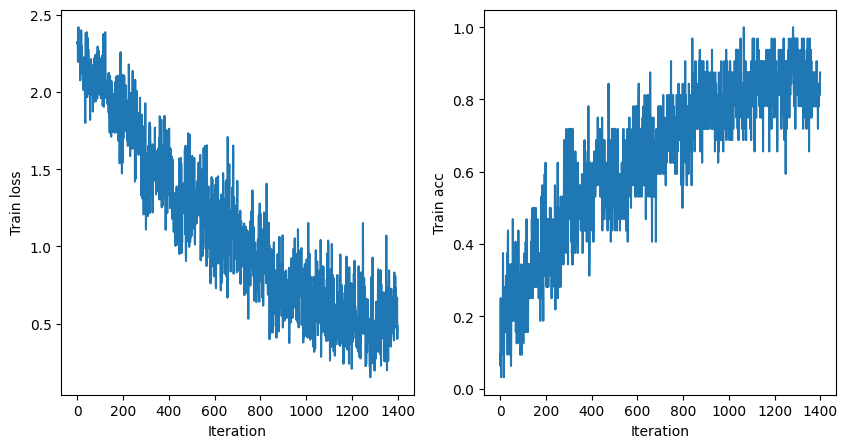

In [ ]:
# обучение модели
train_audio_clfr(rnn_raw, optim, train_dataloader, train_dataset.sr)

**Подсчет метрик на валидационном датасете**

In [ ]:
def plot_confusion_matrix(model, val_dataloader, sr, device, data_transform=None):
    pred_true_pairs = []
    for batch in val_dataloader:
        x = batch["x"].to(device)
        y = batch["y"].to(device)
        lens = batch["len"].to(device)

        with torch.no_grad():
            if data_transform:
                x, lens = data_transform(x, lens, sr=sr, device=device)

            probs = model(x, lens)

            pred_cls = probs.argmax(dim=-1)

        for pred, true in zip(pred_cls.cpu().detach().numpy(), y.cpu().numpy()):
            pred_true_pairs.append((pred, true))

    print(f"Val accuracy: {np.mean([p[0] == p[1] for p in pred_true_pairs])}")

    cm_df = pd.DataFrame(
        confusion_matrix(
            [p[1] for p in pred_true_pairs],
            [p[0] for p in pred_true_pairs],
            normalize="true",
        ),
        columns=classes,
        index=classes,
    )
    sn.heatmap(cm_df, annot=True)

Val accuracy: 0.15080213903743314


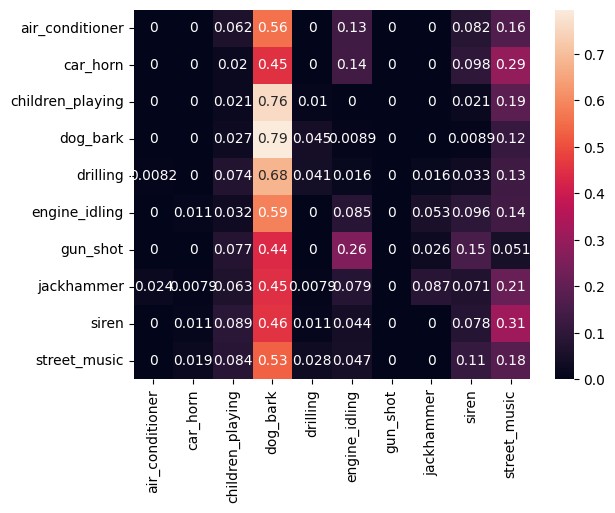

In [ ]:
plot_confusion_matrix(rnn_raw, val_dataloader, train_dataset.sr, device)

Качество модели на тренировочной и валидационной выборке отличается сильно. Причина в переобучении, которое возникает из-за недостаточного кол-ва данных и обучении на сыром сигнале.

#### Собственная реализация алгоритма построения мел-cпектрограмм

Сырой сигнал очень чувствителен ко многим факторам - увеличение/уменьшение громкости, внешние шумы, сменение тембра говорящего очень резко меняют сырой сигнал. Это влияет и на качество глубоких сетей, обученных на сыром аудиосигнале. Поэтому для построения надежных и устойчивых к переобучению моделей используют другое представление аудиоданных - спектрограммы, в том числе мел-спектрограмму.

Идея её построения:
1. Сигнал разбивается на временные интервалы (с пересечениями).
2. К каждому временному интервалу применяется фильтр (как правило косинусоидальный).
3. К профильтрованному сигналу применяется дискретное преобразование Фурье и вычисляются спектральные признаки сигнала.
4. Спектральные признаки с помощью логарифмического преобразования приводятся в мел-шкалу.

<center>
<img src="https://antkillerfarm.github.io/images/img2/Spectrogram_5.png" height="550">
</center>

**Референсная функция для сравнения реализованного алгоритма построения мел-cпектрограмм**

In [ ]:
from torchaudio.transforms import MelSpectrogram

def compute_log_melspectrogram_reference(wav_batch, lens, sr, device="cpu"):
    featurizer = MelSpectrogram(
        sample_rate=sr,
        n_fft=1024,
        win_length=1024,
        hop_length=256,
        n_mels=64,
        center=False,
    ).to(device)

    return torch.log(featurizer(wav_batch).clamp(1e-5)), lens // 256

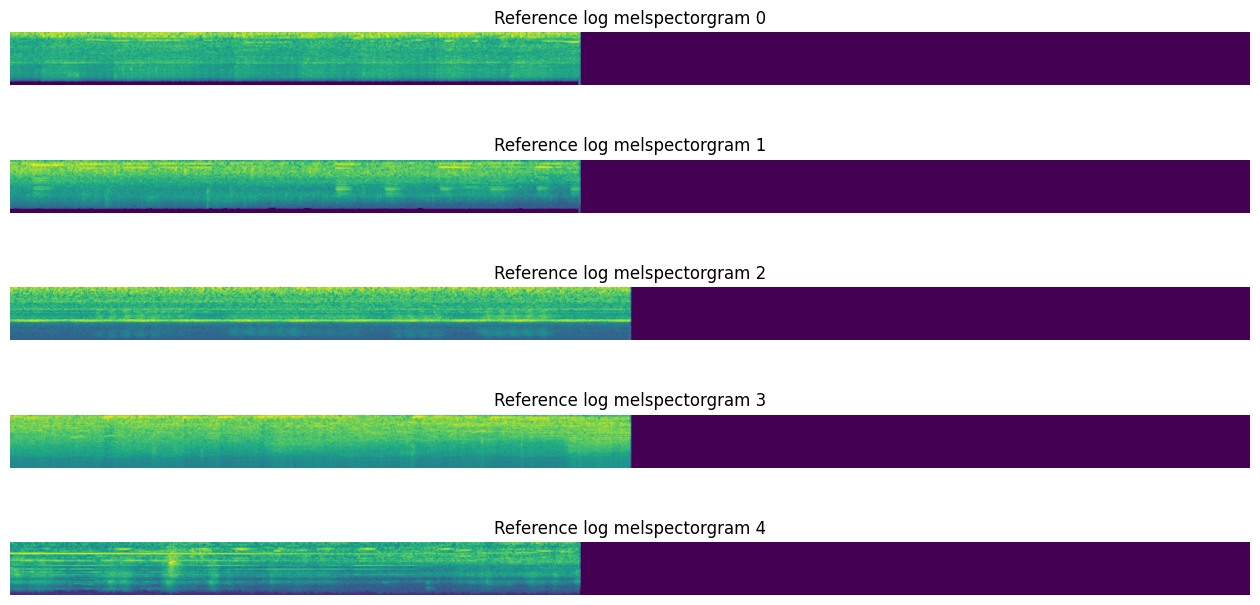

In [ ]:
# возьмем случайный батч
for batch in train_dataloader:
    break

wav_batch = batch["x"]
lens = batch["len"]

# посчитаем лог мелспектрограммы
log_melspect, lens = compute_log_melspectrogram_reference(
    wav_batch, lens, train_dataset.sr
)

# нарисуем получившиеся референсные значения
fig, axes = plt.subplots(5, figsize=(16, 8))

for i in range(5):
    axes[i].axis("off")
    axes[i].set_title(f"Reference log melspectorgram {i}")
    axes[i].imshow(log_melspect[i].numpy())

**Собственный алгоритм**

In [ ]:
sr = train_dataset.sr
n_fft = 1024
win_length = 1024
hop_length = 256
n_mels = 64

Разделение аудиосигнала на окна размера `win_length` через промежутки `hop_length`.

In [ ]:
windows = wav_batch.unfold(1, win_length, hop_length)
assert windows.shape == (32, 1497, 1024)

Отрисовка и проигрывание сигнала из одного окна.

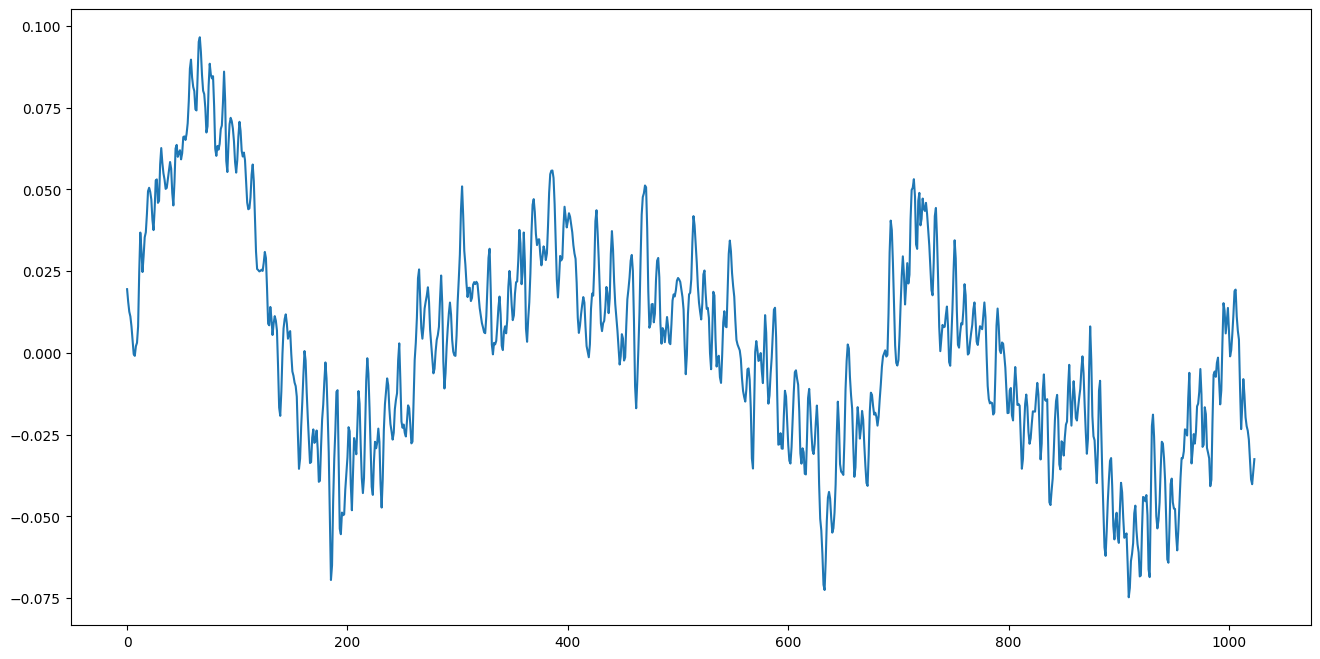

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(windows[0, 0])

display.Audio(windows[0, 0], rate=train_dataset.sr)

Применение косинусоидального фильтра к сигналу из окна.

In [ ]:
filter = torch.hann_window(n_fft)  # создание косинусоидального фильтра
windows_with_applied_filter = windows * filter[None, None, :] # умножение фильтра поэлементно на все окна

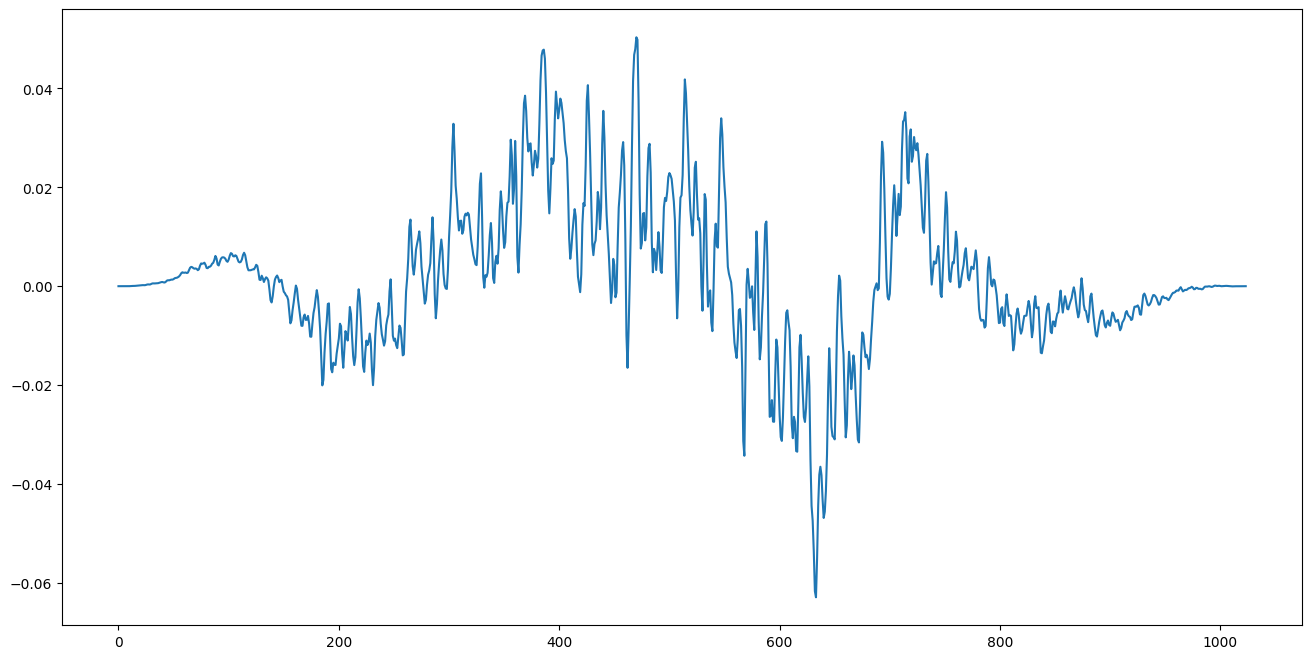

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(windows_with_applied_filter[0, 0])

display.Audio(windows_with_applied_filter[0, 0], rate=train_dataset.sr)

Применение дискретного преобразования Фурье к каждому окну и получение магнитуд.

In [ ]:
fft_features = torch.fft.fft(windows_with_applied_filter, n=n_fft)[:, :, : (n_fft // 2 + 1)]  # берем только первые `n_fft // 2 + 1` компоненты
fft_magnitudes = torch.abs(fft_features**2) # возведение элементов тензора в квадрат и модуль
assert fft_magnitudes.shape == (32, 1497, 513)

Создание класса для перевода магнитуд в мел-шкалу.

In [ ]:
melscale = torchaudio.transforms.MelScale(n_mels=n_mels, sample_rate=sr, n_stft=n_fft // 2 + 1)

Визуализация нелинейного преобразования для перевода в мел-шкалу.

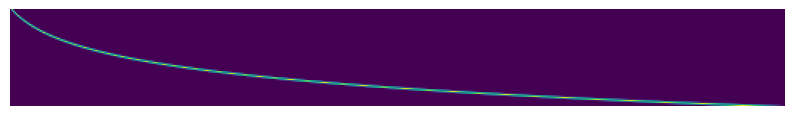

In [ ]:
plt.figure(figsize=(10, 5))
plt.axis("off")
plt.imshow(melscale.fb.numpy().transpose())

Применение мел-шкалы к магнитудам.

In [ ]:
mel_spectrogram = melscale(fft_magnitudes.swapaxes(1, 2))
assert mel_spectrogram.shape == (32, 64, 1497)

Обрезка значений по `1e-5` и получение логарифмированной мел-спектрограммы.

In [ ]:
logmel_spectrogram = torch.log(mel_spectrogram.clamp(1e-5))
assert logmel_spectrogram.shape == (32, 64, 1497)

Сравнение полученных логарифмированных мел-спектрограмм с референсными.

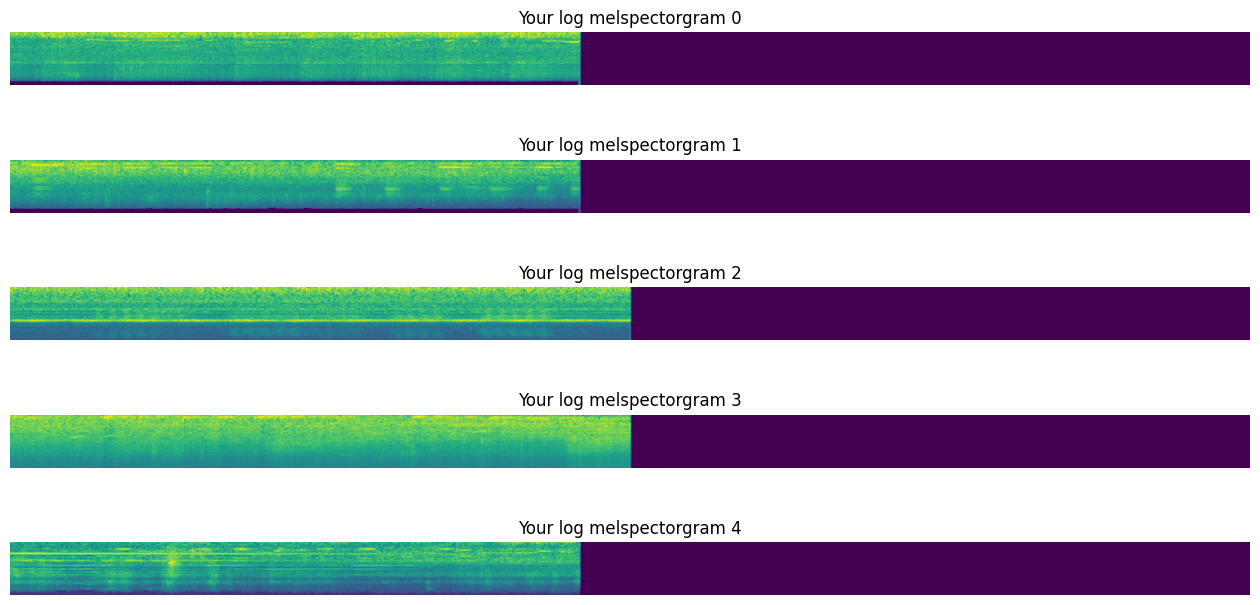

In [ ]:
# нарисуем получившиеся значения
fig, axes = plt.subplots(5, figsize=(16, 8))

for i in range(5):
    axes[i].axis("off")
    axes[i].set_title(f"Your log melspectorgram {i}")
    axes[i].imshow(logmel_spectrogram[i].numpy())

Функция алгоритма построения мел-cпектрограмм.

In [ ]:
def compute_log_melspectrogram(wav_batch, lens, sr, device="cpu"):
    n_fft = 1024
    win_length = 1024
    hop_length = 256
    n_mels = 64

    windows = wav_batch.unfold(1, win_length, hop_length)

    filter = torch.hann_window(n_fft).to(device)
    windows_with_applied_filter = windows * filter[None, None, :]

    fft_features = torch.fft.fft(windows_with_applied_filter, n=n_fft)[:, :, : (n_fft // 2 + 1)]
    fft_magnitudes = torch.abs(fft_features**2)

    melscale = torchaudio.transforms.MelScale(n_mels=n_mels, sample_rate=sr, n_stft=n_fft // 2 + 1).to(device)

    mel_spectrogram = melscale(fft_magnitudes.swapaxes(1, 2)).to(device)

    logmel_spectrogram = torch.log(mel_spectrogram.clamp(1e-5))
    return logmel_spectrogram, lens // 256

Финальная проверка.

In [ ]:
assert torch.allclose(
    compute_log_melspectrogram_reference(wav_batch, lens, train_dataset.sr)[0],
    compute_log_melspectrogram(wav_batch, lens, train_dataset.sr)[0],
    atol=1e-5,
)

#### Рекуррентная сеть для классификации аудиозаписей по логарифмированным мел-спектрограммам

Повторяет рекуррентную сеть для классификации аудиозаписей по сырому сигналу, но вместо сырого сигнала принимает логарифмированные мел-спетрограммы:

Сеть:
1. По логарифмированным мел-спетрограммам проходится двунаправленной LSTM с двумя слоями (вход LSTM равен 64).
2. Склеивает последние `hidden_state` для каждого слоя и применяет к ним полносвязную сеть `(2 * hidden_size * num_layers -> 256 -> 10)` с активацией `ReLU`.

<center>
<img src="https://raw.githubusercontent.com/hse-ds/iad-applied-ds/2020-2023/2022/hw/hw2/imgs/rnn_mel.png" height="500">
</center>

**Реализация класса рекуррентной сети**

In [ ]:
class RecurrentMelSpectClassifier(nn.Module):
    def __init__(
        self,
        num_classes=10,
        window_length=1024,
        hop_length=256,
        hidden=256,
        num_layers=2,
    ) -> None:
        super().__init__()

        self.window_length = window_length
        self.hop_length = hop_length

        self.num_layers = num_layers
        self.hidden = hidden
        self.num_classes = num_classes

        self.rnn = nn.LSTM(
            input_size=64,
            hidden_size=self.hidden,
            num_layers=self.num_layers,
            batch_first=True,
            bidirectional=True,
        )

        self.final_mlp = nn.Sequential(
            nn.Linear(2 * self.hidden * self.num_layers, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, self.num_classes),
            nn.ReLU(),
        )

    def forward(self, x, lens):
        # применение к логарифмированным мел-спетрограммам LSTM
        x = x.swapaxes(1, 2)
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden).to(device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden).to(device)
        _, (hidden_state, _) = self.rnn(x, (h0, c0))

        # выделение у hidden_state размерности, отвечающей за слои
        hidden_state = hidden_state.view(self.num_layers, 2, x.size(0), self.hidden)

        # склеивание hidden_state по слоям
        # hidden_flattened.shape = (B, 2 * hidden_size * num_layers)
        # hidden_state каждого слоя
        hidden_state_1, hidden_state_2 = hidden_state[0], hidden_state[1]
        # конкатенация сначала по направлениям, затем по слоям
        hidden_flattened_1, hidden_flattened_2 = torch.cat((hidden_state_1[0], hidden_state_1[1]), 1), torch.cat((hidden_state_2[0], hidden_state_2[1]), 1)
        hidden_flattened = torch.cat((hidden_flattened_1, hidden_flattened_2), 1)

        # применение полносвязной сети и получение логитов классов
        return self.final_mlp(hidden_flattened)

**Обучение модели**

In [ ]:
rnn_mel = RecurrentMelSpectClassifier()
rnn_mel.to(device)

optim = torch.optim.Adam(rnn_mel.parameters(), lr=1e-4)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_max=10, eta_min=1e-5)

Epoch 9


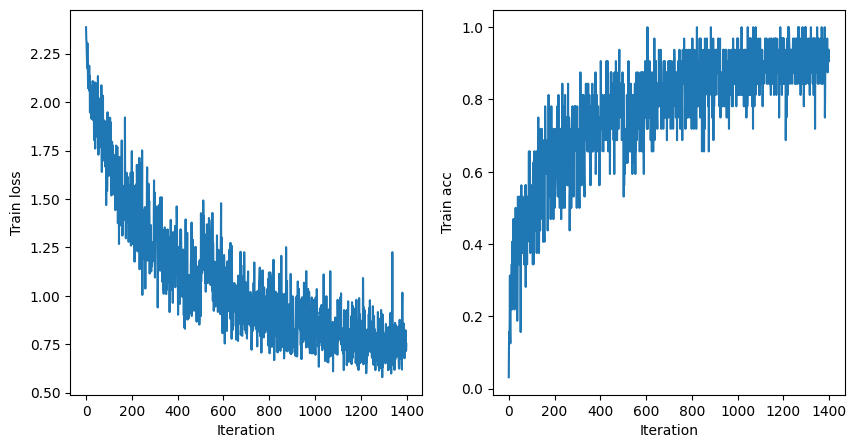

In [ ]:
train_audio_clfr(
    rnn_mel,
    optim,
    train_dataloader,
    train_dataset.sr,
    data_transform=compute_log_melspectrogram,
)

**Подсчет метрик на валидационном датасете**

Val accuracy: 0.8203208556149733


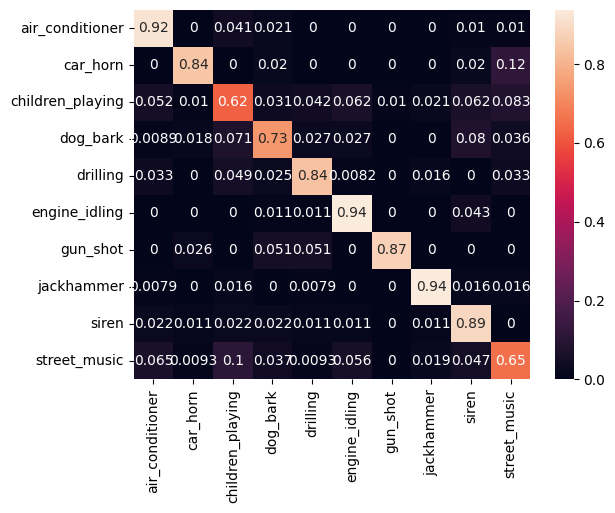

In [ ]:
plot_confusion_matrix(
    rnn_mel,
    val_dataloader,
    train_dataset.sr,
    device,
    data_transform=compute_log_melspectrogram,
)

**Подбор гиперпараметров для получения accuracy модели выше 0.8 на валидационном датасете:**
- сначала просто меняла длину шага
  - lr=3e-4, val acc = 0.68
  - lr=1e-4, val acc = 0.8181
- потом добавила шедулер
  - lr=1e-3 + lr_scheduler.CosineAnnealingLR(eta_min=1e-4), val acc = 0.74
  - lr=1e-4 + lr_scheduler.CosineAnnealingLR(eta_min=1e-5), val acc = 0.81
- добавила label smoothing = 0.1, val acc = 0.82

#### Cверточная сеть для классификации аудиозаписей по мел-спектрограммам

Мел-спектрограммы имеют четко выраженные паттерны - если приноровиться, то даже человек, посмотрев на мел-спектрограмму, сможет _визуально_ проклассифицировать объект. Это позволяет свести задачу классификации аудиозаписей к задаче классификации картинок.

Реализуем такую сверточную сеть:

* 2x (Conv2d 3x3 @ 16, BatchNorm2d, ReLU)
* MaxPoll 2x2
* 2x (Conv2d 3x3 @ 32, BatchNorm2d, ReLU)
* MaxPoll 2x2
* 2x (Conv2d 3x3 @ 64, BatchNorm2d, ReLU)
* MaxPoll 2x2
* (Conv2d 3x3 @ 128, BatchNorm2d, ReLU)
* (Conv2d 2x2 @ 128, BatchNorm2d, ReLU)
* Global MaxPoll
* Fully Connected 128, ReLU
* Fully Connected 10

Подобная архитектура была реализована в [**PANNs: Large-Scale Pretrained Audio Neural Networks for Audio Pattern Recognition**](https://arxiv.org/pdf/1912.10211.pdf).

**Реализация класса сверточной сети**

In [ ]:
class CNN10(nn.Module):
    def __init__(self, num_classes=10, hidden=16):
        super().__init__()

        self.cnn_backbone = nn.Sequential(
            # 1
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3)),
            nn.BatchNorm2d(16),
            nn.ReLU(),

            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3)),
            nn.BatchNorm2d(16),
            nn.ReLU(),

            nn.MaxPool2d(kernel_size=(2, 2)),

            # nn.Dropout(0.2),

            # 2
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3)),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3)),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.MaxPool2d(kernel_size=(2, 2)),

            # nn.Dropout(0.2),

            # 3
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3)),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3)),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(kernel_size=(2, 2)),

            # nn.Dropout(0.2),

            # 4
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3)),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # 5
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(2, 2)),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        self.final_mlp = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),

            nn.Linear(128, 10),
        )

    def forward(self, x, lens):
        z = self.cnn_backbone(x[:, None, :, :])
        z = torch.nn.functional.max_pool2d(z, kernel_size=z.size()[2:])[:, :, 0, 0]
        return self.final_mlp(z)

In [ ]:
CNN10()

CNN10(
  (cnn_backbone): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (11): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (15): BatchNorm2d(64, eps=1e-05, momentum=0.1, affin

**Обучение модели**

In [ ]:
cnn = CNN10()
cnn.to(device)

optim = torch.optim.Adam(cnn.parameters(), lr=1e-3)

Epoch 19


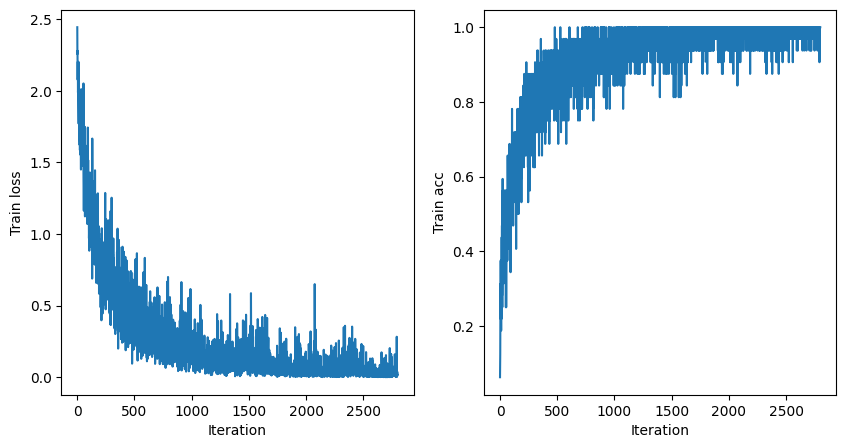

In [ ]:
train_audio_clfr(
    cnn,
    optim,
    train_dataloader,
    train_dataset.sr,
    data_transform=compute_log_melspectrogram,
    num_epochs=20,
)

**Подсчет метрик на валидационном датасете**

Val accuracy: 0.9358288770053476


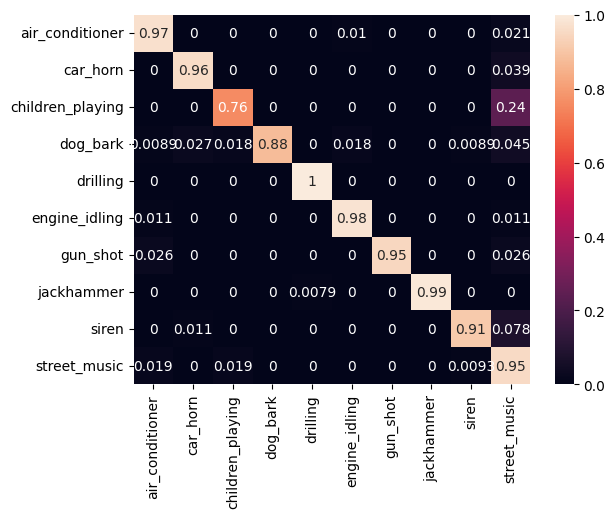

In [ ]:
plot_confusion_matrix(
    cnn,
    val_dataloader,
    train_dataset.sr,
    device,
    data_transform=compute_log_melspectrogram,
)

**Подбор гиперпараметров для получения accuracy модели выше 0.85 на валидационном датасете:**
- сначала меняла только learning rate, лучшей длиной шага оказалась изначальная
  - lr=3e-4, val acc = 0.94
  - lr=1e-4, val acc = 0.91
  - lr=1e-3, val acc = 0.936
- затем решила добавить dropout, как в оригинальной статье, но стало хуже
  - dropout, val acc = 0.91
  - dropout + lr=1e-4, val acc = 0.92

#### Реализация аугментации SpecAugment

Обычно датасеты с аудиозаписями довольно малы. Датасет UrbanSound8K тому пример - всего 4500 объектов в обучающей выборке. Обучение глубоких сетей с большим кол-вом параметров на таких датасетах часто ведет к переобучению и проседанию метрик на валидационном и тестовом датасетах. Для борьбы с переобучением имеет смысл использовать аугментацию данных. Для мел-спектрограмм была придумана аугментация под названием SpecAugment.

Ее смысл - зануление спектрограммы по временным промежуткам и по мел-частотам:
1. Выбираются несколько временных промежутков ${[t^1_i, t^2_i]}$ и заполняют спектрограмму $s[t^1_i : t^2_i, :]$ значением $v$.
2. Выбираются несколько промежутков мел-частот ${[m^1_i, m^2_i]}$ и заполняют спектрограмму $s[:, m^1_i : m^2_i]$ значением $v$.

В качестве значения $v$ выбирают:
1. `'mean'`: среднее по спектрограмме
2. `'min'`: минимум по спектрограмме
3. `'max'`: максимум по спектрограмме
5. `v`: некоторая константа

[Описание аугментации](https://neurohive.io/ru/novosti/specaugment-novyj-metod-augmentacii-audiodannyh-ot-google-ai/).

![specaugment](https://neurohive.io/wp-content/uploads/2019/04/image6.png)



**Реализация класса SpectAugment**

In [ ]:
import random
random.seed(28)

class SpectAugment:
    def __init__(
        self,
        filling_value="mean",
        n_freq_masks=1,
        n_time_masks=1,
        max_freq=10,
        max_time=50,
    ):

        self.filling_value = filling_value
        self.n_freq_masks = n_freq_masks
        self.n_time_masks = n_time_masks
        self.max_freq = max_freq
        self.max_time = max_time

    def __call__(self, spect, lens):
        spect_clone = torch.clone(spect).to(device)

        vv = spect_clone.shape[1]
        tt = spect_clone.shape[2]

        for el in range(spect_clone.shape[0]): # чтобы к каждому объекту из батча применялись свои маски аугментации

            if self.filling_value == 'mean':
              v = torch.mean(spect_clone[el, :, :])
            elif self.filling_value == 'min':
              v = torch.min(spect_clone[el, :, :])
            elif self.filling_value == 'max':
              v = torch.max(spect_clone[el, :, :])
            else:
              v = self.filling_value

            for i in range(self.n_freq_masks):
              f = int(np.random.uniform(0, self.max_freq))
              f0 = random.randint(0, vv - f)
              spect_clone[el, f0 : f0+f, :lens[el]] = v # обрезаем маску также и по длине аудиозаписи

            for i in range(self.n_time_masks):
              t = int(np.random.uniform(0, self.max_time))
              t0 = random.randint(0, tt - t)
              spect_clone[el, :, t0 : min(lens[el], (t0+t))] = v # обрезаем маску также и по длине аудиозаписи

        return spect_clone, lens

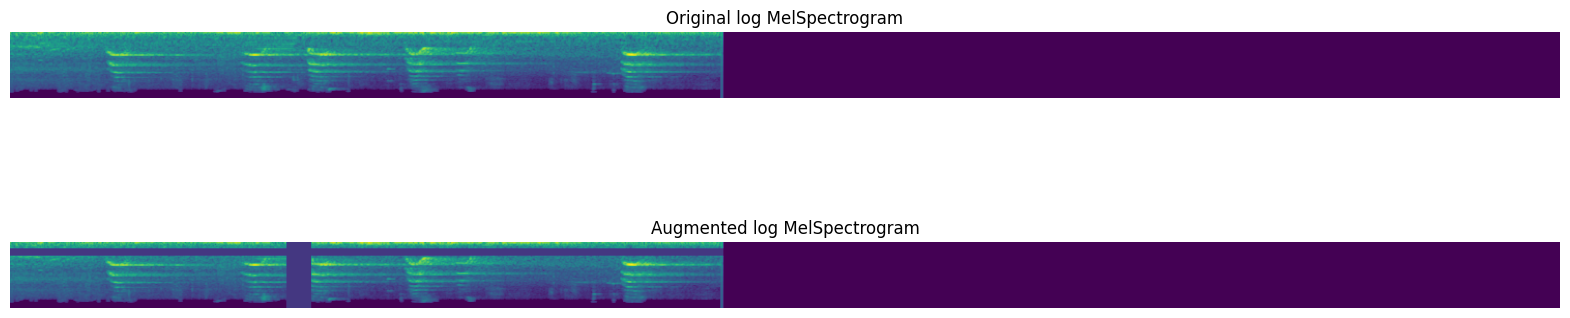

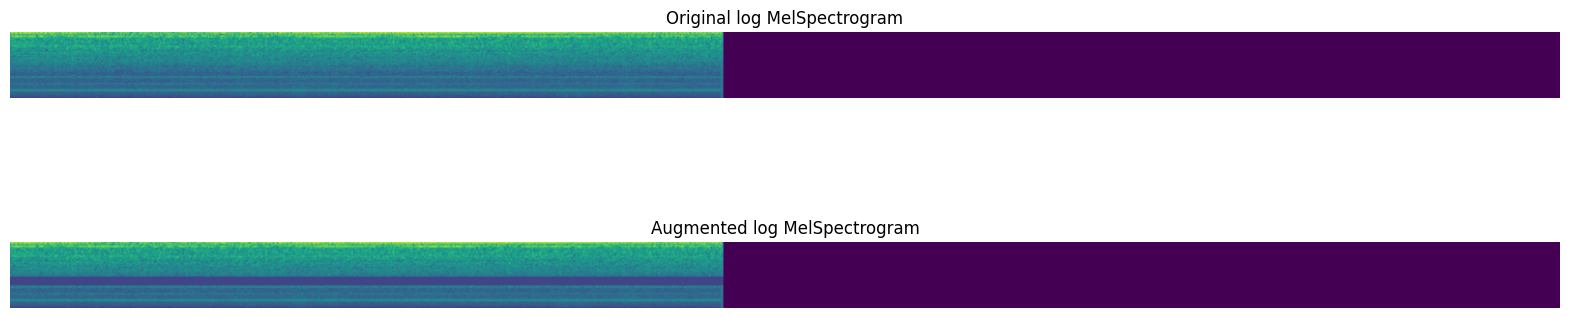

In [ ]:
# применим аугментацию к данным
for batch in train_dataloader:
    break

x = batch["x"].to(device)
lens = batch["len"].to(device)
x_logmel, lens = compute_log_melspectrogram_reference(
    x, lens, sr=train_dataset.sr, device=device
)
x_logmel_augmented, lens = SpectAugment()(x_logmel, lens)

# нарисуем спектрограмму до и после аугментации
plt.figure(figsize=(20, 5))
plt.subplot(2, 1, 1)
plt.title("Original log MelSpectrogram")
plt.axis("off")
plt.imshow(x_logmel[0].cpu().numpy())

plt.subplot(2, 1, 2)
plt.title("Augmented log MelSpectrogram")
plt.axis("off")
plt.imshow(x_logmel_augmented[0].cpu().numpy())

plt.figure(figsize=(20, 5))
plt.subplot(2, 1, 1)
plt.title("Original log MelSpectrogram")
plt.axis("off")
plt.imshow(x_logmel[1].cpu().numpy())

plt.subplot(2, 1, 2)
plt.title("Augmented log MelSpectrogram")
plt.axis("off")
plt.imshow(x_logmel_augmented[1].cpu().numpy())
plt.show()

**Обучение сверточной сети на данных с аугментациями**

In [ ]:
random.seed(28)

cnn = CNN10()
cnn.to(device)

optim = torch.optim.Adam(cnn.parameters(), lr=3e-4)

Epoch 19


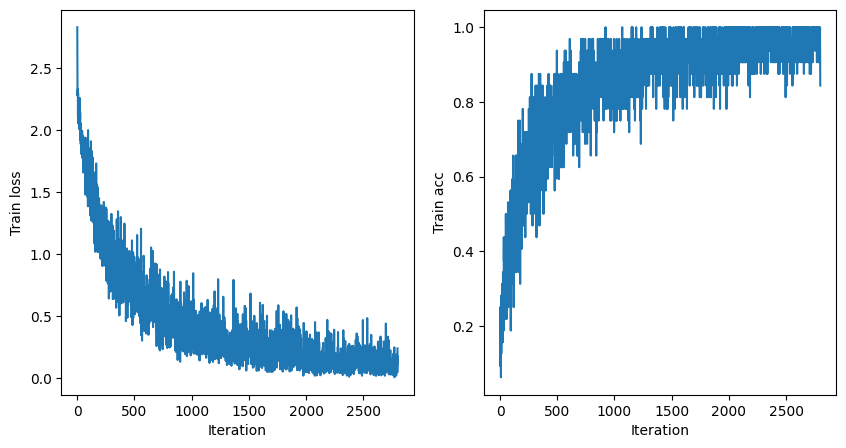

In [ ]:
random.seed(28)

# обучим модель на данных с аугментациями
train_audio_clfr(
    cnn,
    optim,
    train_dataloader,
    train_dataset.sr,
    data_transform=compute_log_melspectrogram,
    augmentation=SpectAugment(),
    num_epochs=20,
)

**Подсчет метрик на валидационном датасете**

Val accuracy: 0.9390374331550803


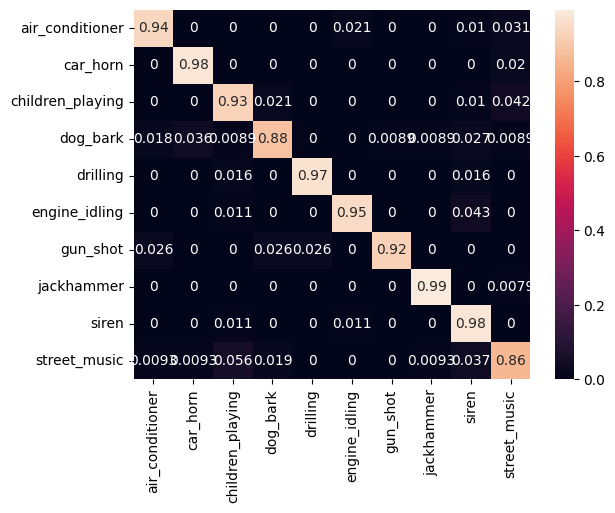

In [ ]:
random.seed(28)

plot_confusion_matrix(
    cnn,
    val_dataloader,
    train_dataset.sr,
    device,
    data_transform=compute_log_melspectrogram,
)

**Подбор параметров аугментации для получения accuracy модели выше 0.9 на валидационном датасете:**
- сначала v считала как среднее спектрограммы батча, val acc = 0.926
- затем стала считать для каждого сэмпла отдельно, val acc = 0.94
- далее в два раза увеличила max_freq и max_time, val acc = 0.9198
- уменьшила max_freq и max_time в два раза по сравнению с исходными, val acc = 0.895
- n_freq_masks и n_time_masks увеличила до 3 (max_freq и max_time - исходные), val acc = 0.906
- n_freq_masks и n_time_masks уменьшила до 1, val acc = 0.939